In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# library imports
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt

In [3]:
from pandas.plotting import scatter_matrix

In [4]:
# scikit imports
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

/usr/local/bin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [6]:
# Class, for use in pipelines, to select certain columns from a DataFrame and convert to a numpy array
# From A. Geron: Hands-On Machine Learning with Scikit-Learn & TensorFlow, O'Reilly, 2017
# Modified by Derek Bridge to allow for casting in the same ways as pandas.DatFrame.astype
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, dtype=None):
        self.attribute_names = attribute_names
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_selected = X[self.attribute_names]
        if self.dtype:
            return X_selected.astype(self.dtype).values
        return X_selected.values

# Class, for use in pipelines, to binarize nominal-valued features (while avoiding the dummy variabe trap)
# By Derek Bridge, 2017
class FeatureBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, features_values):
        self.features_values = features_values
        self.num_features = len(features_values)
        self.labelencodings = [LabelEncoder().fit(feature_values) for feature_values in features_values]
        self.onehotencoder = OneHotEncoder(sparse=False,
            n_values=[len(feature_values) for feature_values in features_values])
        self.last_indexes = np.cumsum([len(feature_values) - 1 for feature_values in self.features_values])
    def fit(self, X, y=None):
        for i in range(0, self.num_features):
            X[:, i] = self.labelencodings[i].transform(X[:, i])
        return self.onehotencoder.fit(X)
    def transform(self, X, y=None):
        for i in range(0, self.num_features):
            X[:, i] = self.labelencodings[i].transform(X[:, i])
        onehotencoded = self.onehotencoder.transform(X)
        return np.delete(onehotencoded, self.last_indexes, axis=1)
    def fit_transform(self, X, y=None):
        onehotencoded = self.fit(X).transform(X)
        return np.delete(onehotencoded, self.last_indexes, axis=1)
    def get_params(self, deep=True):
        return {"features_values" : self.features_values}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.setattr(parameter, value)
        return self
    


In [7]:
bank_data_set = pd.read_csv("dataset/bank-additional.csv", sep=";");

In [8]:
bank_data_set.shape

(4119, 21)

In [9]:
bank_data_set.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [10]:
bank_data_set.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [11]:
bank_data_set.describe(include='all')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,4119.000000,4119,4119,4119,4119,4119,4119,4119,4119,4119,...,4119.000000,4119.000000,4119.000000,4119,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,1012,2509,1264,3315,2175,3349,2652,1378,860,...,NaN,NaN,NaN,3523,NaN,NaN,NaN,NaN,NaN,3668
mean,40.113620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.537266,960.422190,0.190337,NaN,0.084972,93.579704,-40.499102,3.621356,5166.481695,NaN
std,10.313362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.568159,191.922786,0.541788,NaN,1.563114,0.579349,4.594578,1.733591,73.667904,NaN
min,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.635000,4963.600000,NaN
25%,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.334000,5099.100000,NaN
50%,38.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


In [12]:
# where pdays is 999: client was not previously contacted.
# more than 95% was not contacted, we should probably drop this feature or turn it into binary.
(bank_data_set["pdays"] == 999).sum() / len(bank_data_set)

0.9611556202961884

In [13]:
(bank_data_set["previous"] == 0).sum() / len(bank_data_set)

0.85530468560330175

In [14]:
(bank_data_set["poutcome"] == "nonexistent").sum() / len(bank_data_set)

0.85530468560330175

# Cleaning the dataset 

In [15]:
nominal_features = ["job", "marital", "education", "default", "housing", 
                    "loan", "contact", "month", "day_of_week", 
                   ]
# N.B. pdays, previous, poutcome is removed
numeric_features = ["age", "campaign", "emp.var.rate", 
                    "cons.price.idx", "euribor3m", "nr.employed",
                   ]

In [16]:
for feature in nominal_features:
    nr_missing = (bank_data_set[feature] == "unknown").sum()
    ratio = nr_missing / len(bank_data_set)
    print (feature, nr_missing, ratio)

job 39 0.0094683175528
marital 11 0.00267055110464
education 167 0.0405438213159
default 803 0.194950230639
housing 105 0.0254916241806
loan 105 0.0254916241806
contact 0 0.0
month 0 0.0
day_of_week 0 0.0


In [17]:
# delete unknowns from the dataset
bank_df_without_unknown = (bank_data_set[(bank_data_set["job"] != "unknown") & 
                        (bank_data_set["marital"] != "unknown") &
                        (bank_data_set["education"] != "unknown") &
                        (bank_data_set["housing"] != "unknown") &
                        (bank_data_set["loan"] != "unknown")
                       ]).copy()
bank_df_without_unknown.reset_index(inplace=True, drop=True)

In [18]:
bank_df = bank_df_without_unknown[
    (bank_df_without_unknown["campaign"] < 15)
].copy()

bank_df.reset_index(inplace=True, drop=True)

In [19]:
# impute values of default
mode = bank_df["default"].mode()
actual_mode = mode[0]
bank_df["default"] = (bank_df["default"]).replace("unknown", actual_mode)

In [20]:
bank_df[nominal_features].describe(include='all')

,job,marital,education,default,housing,loan,contact,month,day_of_week
count,3778,3778,3778,3778,3778,3778,3778,3778,3778
unique,11,3,7,2,2,2,2,10,5
top,admin.,married,university.degree,no,yes,no,cellular,may,mon
freq,963,2312,1230,3777,2057,3147,2458,1269,792


In [21]:
bank_df[numeric_features].describe(include='all')

,age,campaign,emp.var.rate,cons.price.idx,euribor3m,nr.employed
count,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000
mean,39.959502,2.393065,0.077131,93.571114,3.614574,5166.530016
std,10.217062,2.024166,1.559450,0.578549,1.730575,73.290142
min,19.000000,1.000000,-3.400000,92.201000,0.635000,4963.600000
25%,32.000000,1.000000,-1.800000,93.075000,1.334000,5099.100000
50%,38.000000,2.000000,1.100000,93.444000,4.857000,5191.000000
75%,47.000000,3.000000,1.400000,93.994000,4.961000,5228.100000
max,88.000000,14.000000,1.400000,94.767000,5.045000,5228.100000


In [22]:
bank_df["y"] = bank_df["y"].map({'yes' : 1, 'no' : 0})

In [23]:
bank_df.describe(include='all')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,3778.000000,3778,3778,3778,3778,3778,3778,3778,3778,3778,...,3778.000000,3778.000000,3778.000000,3778,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000
unique,NaN,11,3,7,2,2,2,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,mon,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,963,2312,1230,3777,2057,3147,2458,1269,792,...,NaN,NaN,NaN,3235,NaN,NaN,NaN,NaN,NaN,NaN
mean,39.959502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.393065,961.139492,0.185813,NaN,0.077131,93.571114,-40.558232,3.614574,5166.530016,0.109317
std,10.217062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.024166,190.220934,0.525132,NaN,1.559450,0.578549,4.615916,1.730575,73.290142,0.312078
min,19.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.635000,4963.600000,0.000000
25%,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.334000,5099.100000,0.000000
50%,38.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.444000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000


# Visualizing the dataset 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd182cd1d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd177fcce48>]], dtype=object)

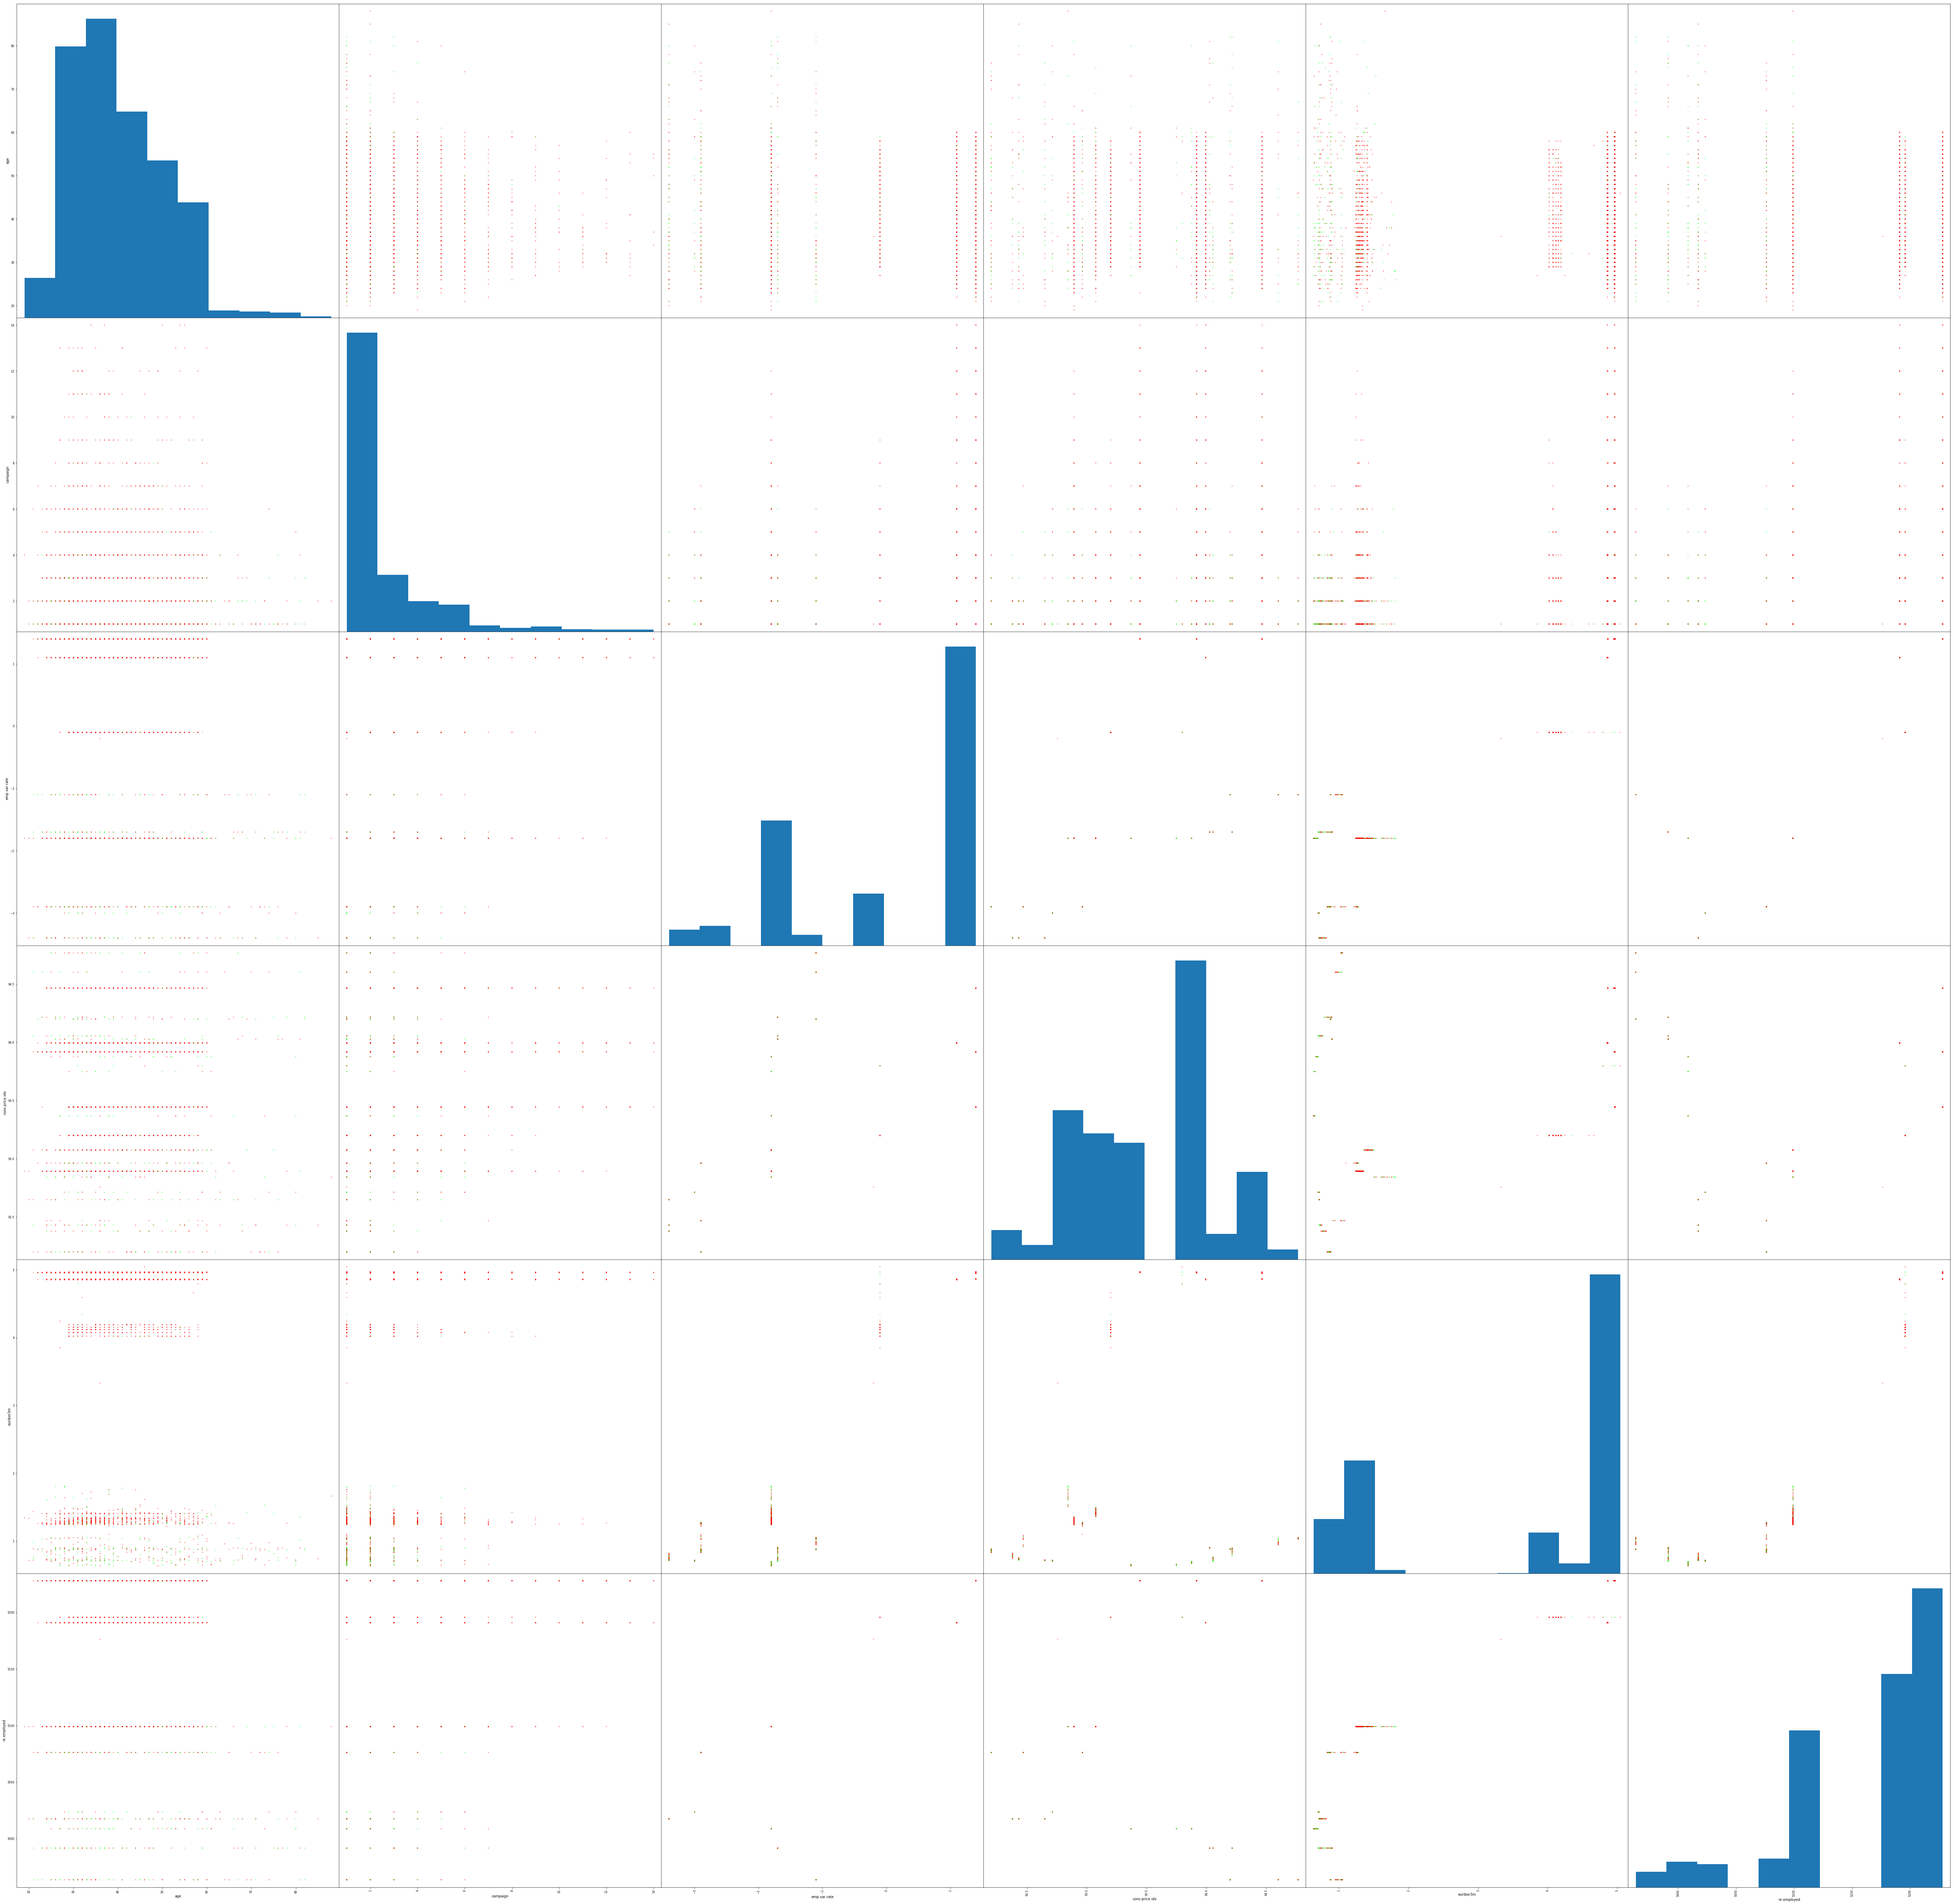

In [46]:
selected_features = bank_df[numeric_features]

color_map = {
    0 : '#FF0000',
    1 : '#00FF00'
}

colors = bank_df["y"].map(color_map)

scatter_matrix(selected_features, figsize=(100, 100), color=colors)

# Builing the pipelines (classifiers) 

In [25]:
numeric_pipeline = Pipeline([
    ('selector', DataFrameSelector(numeric_features)),
    ('scaler', StandardScaler())
])

nominal_pipeline = Pipeline([
    ('selector', DataFrameSelector(nominal_features)),
    ('binarizer', FeatureBinarizer([bank_df[feature].unique() for feature in nominal_features])),
])

union = FeatureUnion([
        ('nominal_pipeline', nominal_pipeline),
        ('numeric_pipeline', numeric_pipeline),
    ])

## Dummy classifier 

In [26]:
dummy_pipeline = make_pipeline(
    union,
    # RandomOverSampler({'yes' : 2000}), does not matter if we oversample
    DummyClassifier(strategy='most_frequent')
)

## SVM with adaboost

In [27]:
pipeline = Pipeline([
    ('union', union),
    ('pca', PCA()),
    ('clf', svm.SVC())
])

In [64]:
svm_C_params = [0.5, 1.5]
svm_kernels_param = ['linear']
svm_degree_param = [3]
class_weights_params = ['balanced', {1 : 5, 0 : 1}]

rnd_forest_crit = ['gini']

pca_params = [None]

params = [
    {
        'pca__n_components' : pca_params,
        'clf' : [svm.SVC()], 
        'clf__C' : svm_C_params,
        'clf__degree' : svm_degree_param,
        'clf__kernel' : svm_kernels_param,
        'clf__class_weight' : class_weights_params,
    },
    
    #{
    #    'pca__n_components' : pca_params,
    #    'clf' : [RandomForestClassifier(max_depth=3)],
    #    'clf__criterion' : rnd_forest_crit,
    #    'clf__class_weight' : class_weights_params,
    #},
    
    #{
    #    'pca__n_components' : pca_params,
    #    'clf' : [AdaBoostClassifier(svm.SVC(kernel='linear'), n_estimators=25, algorithm='SAMME')],
    #    'clf__base_estimator__C' : svm_C_params,
    #    'clf__base_estimator__degree' : svm_degree_param,
    #    'clf__base_estimator__class_weight' : class_weights_params,
    #},
    
    {
        'clf' : [MLPClassifier(max_iter=500)],
        'clf__hidden_layer_sizes' : [(333, 267), (300, 150, 50)] 
    }
]

In [65]:
def grid_search(pipeline, params, df):
    scoring = {
        'AUC' : 'roc_auc',
        'recall' : 'recall',
        'precision' : 'precision',
        'accuracy' : 'accuracy',
        'f1' : 'f1'
    }
    
    grid = GridSearchCV(pipeline, params, scoring=scoring, cv=10, n_jobs=-1, refit="f1")
    grid.fit(df, df["y"])
    
    return grid

In [66]:
grid = grid_search(pipeline, params, bank_df)

In [67]:
auc = grid.cv_results_['mean_test_AUC'][grid.best_index_]
recall = grid.cv_results_['mean_test_recall'][grid.best_index_]
precision = grid.cv_results_['mean_test_precision'][grid.best_index_]
accuracy = grid.cv_results_['mean_test_accuracy'][grid.best_index_]
f1 = grid.best_score_

print("auc: ", auc)
print ("recall: ", recall)
print("precision: ", precision)
print("accuracy: ", accuracy)
print("f1: ", f1)

auc:  0.730165868303
recall:  0.523413103185
precision:  0.444286223514
accuracy:  0.875595553203
f1:  0.477614540794


In [45]:
grid.best_params_

{'clf': SVC(C=0.5, cache_size=200, class_weight={1: 5, 0: 1}, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'clf__C': 0.5,
 'clf__class_weight': {0: 1, 1: 5},
 'clf__degree': 3,
 'clf__kernel': 'linear',
 'pca__n_components': None}